# MUSA550 Geospatial Data Science in Python - Assignment 3

### Hang Zhao

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

# See lots of columns
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

# Assignment 3

This assignment will contain two parts:

1. Exploring evictions and code violations in Philadelphia
2. Comparing the NDVI in Philadelphia

## Part 1: Exploring Evictions and Code Violations in Philadelphia

In this assignment, we'll explore spatial trends evictions in Philadelphia using data from the [Eviction Lab](https://evictionlab.org/) and building code violations using data from [OpenDataPhilly](https://www.opendataphilly.org/).

We'll be exploring the idea that evictions can occur as retaliation against renters for reporting code violations. Spatial correlations between evictions and code violations from the City's Licenses and Inspections department can offer some insight into this question. 

**A couple of interesting background readings:**
- [HuffPost article](https://www.huffingtonpost.com/entry/cities-are-starting-to-pay-attention-to-the-eviction-crisis-thats-devastated-poor-tenants_us_5b1a7b21e4b0bbb7a0dbd59e)
- [PlanPhilly article](http://planphilly.com/articles/2018/04/12/philly-landlords-evict-more-people-than-owners-in-other-large-cities)

## 1.1 Explore Eviction Lab Data

The Eviction Lab built the first national database for evictions. If you aren't familiar with the project, you can explore their website: https://evictionlab.org/ 

### 1.1.1 Read data using `geopandas`

The first step is to read the eviction data by census tract using `geopandas`. The data for all of Pennsylvania by census tract is available in the `data/` folder in a GeoJSON format.

Load the data file "PA-tracts.geojson" using `geopandas`

**Note:** If you'd like to see all columns in the data frame, you can increase the max number of columns using pandas display options:

In [2]:
PA_Census = gpd.read_file("data/PA-tracts.geojson")

### 1.1.2 Explore and trim the data 

We will need to trim data to Philadelphia only. Take a look at the data dictionary for the descriptions of the various columns in top-level repository folder: `eviction_lab_data_dictionary.txt`

**Note:** the column names are shortened — see the end of the above file for the abbreviations. The numbers at the end of the columns indicate the years. For example, `e-16` is the number of evictions in 2016. 

Take a look at the individual columns and trim to census tracts in Philadelphia. (**Hint:** Philadelphia is both a city and a county).

In [3]:
philly = PA_Census.loc[PA_Census['pl'] == 'Philadelphia County, Pennsylvania']

### 1.1.3 Transform from wide to tidy format

For this assignment, we are interested in the number of evictions by census tract for various years. Right now, each year has it's own column, so it will be easiest to transform to a tidy format. 

Use the `pd.melt()` function to transform the eviction data into tidy format, using the number of evictions from **2003 to 2016**.

The tidy data frame should have four columns: `GEOID`, `geometry`, a column holding the number of evictions, and a column telling you what the name of the original column was for that value.

**Hints:**
- You'll want to specify the `GEOID` and `geometry` columns as the `id_vars`. This will keep track of the census tract information. 
- You should specify the names of the columns holding the number of evictions as the `value_vars`.
- You can generate a list of this column names using Python's f-string formatting:
    ```python
    value_vars = [f"e-{x:02d}" for x in range(3, 17)]
    ```

In [4]:
value_vars = [f"e-{x:02d}" for x in range(3, 17)]
philly = philly.melt(id_vars=['GEOID','geometry'], value_vars=value_vars, var_name='year', value_name='evictions')

In [5]:
philly.head(n=10)

GEOID                                           geometry  year  \
0  42101000100  MULTIPOLYGON (((-75.14161 39.95549, -75.14163 ...  e-03   
1  42101000200  MULTIPOLYGON (((-75.15122 39.95686, -75.15167 ...  e-03   
2  42101000300  MULTIPOLYGON (((-75.16234 39.95782, -75.16237 ...  e-03   
3  42101000801  MULTIPOLYGON (((-75.17732 39.95096, -75.17784 ...  e-03   
4  42101000804  MULTIPOLYGON (((-75.17118 39.94778, -75.17102 ...  e-03   
5  42101001002  MULTIPOLYGON (((-75.14919 39.94903, -75.14602 ...  e-03   
6  42101001400  MULTIPOLYGON (((-75.16558 39.94366, -75.16567 ...  e-03   
7  42101002100  MULTIPOLYGON (((-75.18062 39.93582, -75.17984 ...  e-03   
8  42101018800  MULTIPOLYGON (((-75.10971 39.99233, -75.11026 ...  e-03   
9  42101019000  MULTIPOLYGON (((-75.09704 40.01602, -75.09656 ...  e-03   

   evictions  
0       21.0  
1        3.0  
2       17.0  
3       13.0  
4       21.0  
5       16.0  
6       30.0  
7        8.0  
8       75.0  
9       43.0

### 1.1.4 Plot the total number of evictions per year from 2003 to 2016

Use `hvplot` to plot the total number of evictions from 2003 to 2016. You will first need to perform a group by operation and sum up the total number of evictions for all census tracts, and then use `hvplot()` to make your plot.

You can use any type of `hvplot` chart you'd like to show the trend in number of evictions over time.

In [6]:
import holoviews as hv
import hvplot.pandas
hv.extension("bokeh")

In [7]:
philly_grouped = philly.groupby("year", as_index=False)["evictions"].sum()
philly_grouped

year  evictions
0   e-03    10647.0
1   e-04    10491.0
2   e-05    10550.0
3   e-06    11078.0
4   e-07    11032.0
5   e-08    10866.0
6   e-09     9821.0
7   e-10    10628.0
8   e-11    10882.0
9   e-12    11130.0
10  e-13    10803.0
11  e-14    11182.0
12  e-15    10098.0
13  e-16    10264.0

In [8]:
philly_grouped.hvplot(x='year', y='evictions', kind="line")

:Curve   [year]   (evictions)

### 1.1.5 The number of evictions across Philadelphia

Our tidy data frame is still a GeoDataFrame with a geometry column, so we can visualize the number of evictions for all census tracts. 

Use `hvplot()` to generate a choropleth showing the number of evictions for a specified year, with a widget dropdown to select a given year (or variable name, e.g., `e-16`, `e-15`, etc). 

**Hints** 
- You'll need to use the `groupby` keyword to tell `hvplot` to make a series of maps, with a widget to select between them.
- You will need to specify `dynamic=False` as a keyword argument to the `hvplot()` function. 
- Be sure to specify a `width` and `height` that makes your output map (roughly) square to limit distortions

In [9]:
# Via hvplot

choro = philly.to_crs(epsg=3857).hvplot(
    c="evictions",
    frame_width=600,
    frame_height=600,
    groupby='year',
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="inferno",
)
choro
# gvts.EsriImagery * choro

:DynamicMap   [year]
   :Polygons   [Longitude,Latitude]   (evictions)

## 1.2 Code Violations in Philadelphia

Next, we'll explore data for code violations from the Licenses and Inspections Department of Philadelphia to look for potential correlations with the number of evictions.


### 1.2.1 Load data from 2012 to 2016

L+I violation data for years including 2012 through 2016 (inclusive) is provided in a CSV format in the "data/" folder. 

Load the data using pandas and convert to a GeoDataFrame.

In [10]:
# Load the data from a CSV file into a pandas DataFrame
violation_df = pd.read_csv(
    "data/li_violations.csv"  # Use the file path relative to the current folder
)

# Remove rows with missing geometry
violation_df = violation_df.dropna(subset=["lat", "lng"])

# Create our GeoDataFrame with geometry column created from lon/lat
violation = gpd.GeoDataFrame(
    violation_df,
    geometry=gpd.points_from_xy(violation_df["lng"], violation_df["lat"]),
    crs="EPSG:4326",
)

In [11]:
violation_0 = gpd.GeoDataFrame(
    violation_df, geometry=gpd.points_from_xy(violation_df.lng, violation_df.lat), crs="EPSG:4326"
)
violation_0

lat        lng            violationdescription  \
0       40.050526 -75.126076           CLIP VIOLATION NOTICE   
1       40.050593 -75.126578       LICENSE-CHANGE OF ADDRESS   
2       40.050593 -75.126578             LICENSE-RES SFD/2FD   
3       39.991994 -75.128895        EXT A-CLEAN WEEDS/PLANTS   
4       40.023260 -75.164848  EXT A-VACANT LOT CLEAN/MAINTAI   
...           ...        ...                             ...   
434047  40.012805 -75.155963           SD-REQD EXIST GROUP R   
434048  40.009985 -75.068968  RUBBISH/GARBAGE EXTERIOR-OWNER   
434049  40.009829 -75.068912           CLIP VIOLATION NOTICE   
434050  40.009776 -75.068895     PERSONAL PROPERTY EXT OWNER   
434051  40.009776 -75.068895       LICENSE - RENTAL PROPERTY   

                          geometry  
0       POINT (-75.12608 40.05053)  
1       POINT (-75.12658 40.05059)  
2       POINT (-75.12658 40.05059)  
3       POINT (-75.12889 39.99199)  
4       POINT (-75.16485 40.02326)  
...                            ...  
434047  POINT (-75.15596 40.01281)  
434048  POINT (-75.06897 40.00999)  
434049  POINT (-75.06891 40.00983)  
434050  POINT (-75.06889 40.00978)  
434051  POINT (-75.06889 40.00978)  

[434052 rows x 4 columns]

### 1.2.2 Trim to specific violation types

There are many different types of code violations (running the `nunique()` function on the `violationdescription` column will extract all of the unique ones). More information on different types of violations can be found [on the City's website](https://www.phila.gov/li/codesandregulations/Pages/codes.aspx).

Below, I've selected 15 types of violations that deal with property maintenance and licensing issues. We'll focus on these violations. The goal is to see if these kinds of violations are correlated spatially with the number of evictions in a given area. 

Use the list of violations given to trim your data set to only include these types.

In [12]:
violation['violationdescription'].nunique()

1342

In [13]:
violation_types = [
    "INT-PLMBG MAINT FIXTURES-RES",
    "INT S-CEILING REPAIR/MAINT SAN",
    "PLUMBING SYSTEMS-GENERAL",
    "CO DETECTOR NEEDED",
    "INTERIOR SURFACES",
    "EXT S-ROOF REPAIR",
    "ELEC-RECEPTABLE DEFECTIVE-RES",
    "INT S-FLOOR REPAIR",
    "DRAINAGE-MAIN DRAIN REPAIR-RES",
    "DRAINAGE-DOWNSPOUT REPR/REPLC",
    "LIGHT FIXTURE DEFECTIVE-RES",
    "LICENSE-RES SFD/2FD",
    "ELECTRICAL -HAZARD",
    "VACANT PROPERTIES-GENERAL",
    "INT-PLMBG FIXTURES-RES",
]
violation_sel = violation_0['violationdescription'].isin(violation_types)
violation_15 = violation_0.loc[violation_sel]

### 1.2.3 Make a hex bin map

The code violation data is **point data**. We can get a quick look at the geographic distribution using `matplotlib` and the `hexbin()` function. Make a hex bin map of the code violations and overlay the census tract outlines. 

**Hints**:
- The eviction data from part 1 was by census tract, so the census tract geometries are available as part of that GeoDataFrame. You can use it to overlay the census tracts on your hex bin map.
- Make sure you convert your GeoDataFrame to a CRS that's better for visualization than plain old 4326.

In [14]:
violation_3857 = violation_15.to_crs(epsg=3857)

In [15]:
from matplotlib import pyplot as plt

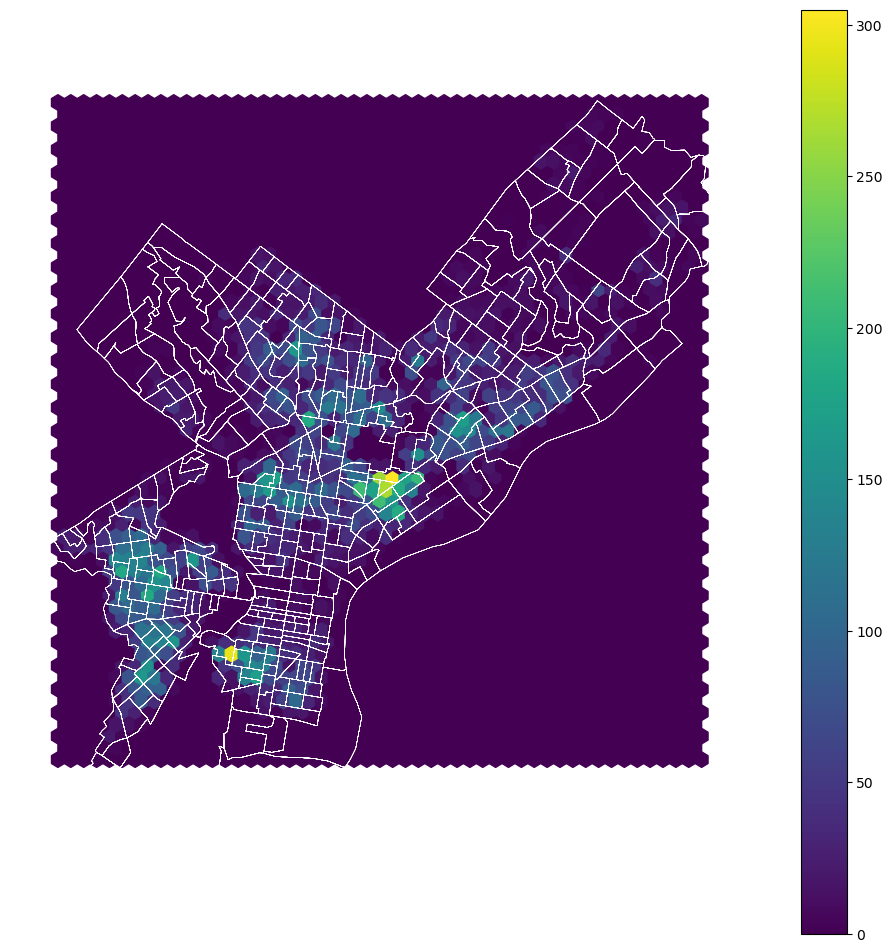

In [16]:
# Create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Extract out the x/y coordindates of the Point objects
xcoords = violation_3857.geometry.x
ycoords = violation_3857.geometry.y

# Plot a hexbin chart
# NOTE: We are passing the full set of coordinates to matplotlib
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=50)


# Add the philly census tract geometry boundaries
philly.to_crs(violation_3857.crs).plot(
    ax=ax, facecolor="none", edgecolor="white", linewidth=0.25
)

# Add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

### 1.2.4 Spatially join data sets

To do a census tract comparison to our eviction data, we need to find which census tract each of the code violations falls into. Use the `geopandas.sjoin()` function to do just that. 


**Hints**
- You can re-use your eviction data frame, but you will only need the `geometry` column (specifying census tract polygons) and the `GEOID` column (specifying the name of each census tract).
- Make sure both data frames have the same CRS before joining them together!

In [17]:
violation_tract = gpd.sjoin(
    violation_3857,  
    philly.to_crs(violation_3857.crs),  
    predicate="intersects",
    how="inner",
).drop(columns=["index_right", "lat", "evictions", "lng", "year"])
violation_tract.head()

violationdescription                          geometry  \
2                 LICENSE-RES SFD/2FD  POINT (-8363052.408 4873297.042)   
16024              CO DETECTOR NEEDED  POINT (-8363202.689 4872597.863)   
17225             LICENSE-RES SFD/2FD  POINT (-8363040.274 4872575.906)   
43436  INT S-CEILING REPAIR/MAINT SAN  POINT (-8362971.479 4872591.029)   
43452               EXT S-ROOF REPAIR  POINT (-8362970.588 4872596.991)   

             GEOID  
2      42101027100  
16024  42101027100  
17225  42101027100  
43436  42101027100  
43452  42101027100

### 1.2.5 Calculate the number of violations by type per census tract

Next, we'll want to find the number of violations (for each kind) per census tract. You should group the data frame by violation type and census tract name.

The result of this step should be a data frame with three columns: `violationdescription`, `GEOID`, and `N`, where `N` is the number of violations of that kind in the specified census tract.

**Optional: to make prettier plots**

Some census tracts won't have any violations, and they won't be included when we do the above calculation. However, there is a trick to set the values for those census tracts to be zero. After you calculate the sizes of each violation/census tract group, you can run: 

```python
N = N.unstack(fill_value=0).stack().reset_index(name='N')
```
where `N` gives the total size of each of the groups, specified by violation type and census tract name.

See [this StackOverflow post](https://stackoverflow.com/questions/42854801/including-missing-combinations-of-values-in-a-pandas-groupby-aggregation) for more details.

This part is **optional**, but will make the resulting maps a bit prettier.

In [18]:
Nviolation_tract = violation_tract.groupby(["violationdescription","GEOID"]).size()
Nviolation_tract = Nviolation_tract.unstack(fill_value=0).stack().reset_index(name='N')

In [19]:
#merged[merged['GEOID']=='42101980800']

### 1.2.6 Merge with census tracts geometries

We now have the number of violations of different types per census tract specified as a regular DataFrame. You can now merge it with the census tract geometries (from your eviction data GeoDataFrame) to create a GeoDataFrame. 

**Hints**
- Use `pandas.merge()` and specify the `on` keyword to be the column holding census tract names. 
- Make sure the result of the merge operation is a GeoDataFrame — you will want the GeoDataFrame holding census tract geometries to be the first argument of the `pandas.merge()` function.

In [20]:
# Do GeoDataFrame.merge(DataFrame) here...
philly_projected = philly.to_crs(violation_3857.crs)
philly_projected=philly_projected[['GEOID','geometry']].drop_duplicates()
merged = philly_projected.merge(Nviolation_tract, on="GEOID")
merged

GEOID                                           geometry  \
0     42101000100  MULTIPOLYGON (((-8364725.429 4859476.459, -836...   
1     42101000100  MULTIPOLYGON (((-8364725.429 4859476.459, -836...   
2     42101000100  MULTIPOLYGON (((-8364725.429 4859476.459, -836...   
3     42101000100  MULTIPOLYGON (((-8364725.429 4859476.459, -836...   
4     42101000100  MULTIPOLYGON (((-8364725.429 4859476.459, -836...   
...           ...                                                ...   
5530  42101018400  MULTIPOLYGON (((-8355531.552 4864854.203, -835...   
5531  42101018400  MULTIPOLYGON (((-8355531.552 4864854.203, -835...   
5532  42101018400  MULTIPOLYGON (((-8355531.552 4864854.203, -835...   
5533  42101018400  MULTIPOLYGON (((-8355531.552 4864854.203, -835...   
5534  42101018400  MULTIPOLYGON (((-8355531.552 4864854.203, -835...   

                violationdescription    N  
0                 CO DETECTOR NEEDED    0  
1      DRAINAGE-DOWNSPOUT REPR/REPLC   84  
2     DRAINAGE-MAIN DRAIN REPAIR-RES    0  
3      ELEC-RECEPTABLE DEFECTIVE-RES    0  
4                 ELECTRICAL -HAZARD   14  
...                              ...  ...  
5530               INTERIOR SURFACES   28  
5531             LICENSE-RES SFD/2FD  154  
5532     LIGHT FIXTURE DEFECTIVE-RES    0  
5533        PLUMBING SYSTEMS-GENERAL   28  
5534       VACANT PROPERTIES-GENERAL    0  

[5535 rows x 4 columns]

### 1.2.7 Interactive choropleths for each violation type

Now, we can use `hvplot()` to create an interactive choropleth for each violation type and add a widget to specify different violation types. 

**Hints** 
- You'll need to use the `groupby` keyword to tell `hvplot` to make a series of maps, with a widget to select different violation types.
- You will need to specify `dynamic=False` as a keyword argument to the `hvplot()` function. 
- Be sure to specify a `width` and `height` that makes your output map (roughly) square to limit distortions

In [21]:
# Via hvplot

choro2 = merged.to_crs(epsg=3857).hvplot(
    c="N",
    frame_width=600,
    frame_height=600,
    groupby='violationdescription',
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="magma",
    #hover_cols=["GEOID"]
)
choro2

:DynamicMap   [violationdescription]
   :Polygons   [Longitude,Latitude]   (N)

## 1.3. A side-by-side comparison

From the interactive maps of evictions and violations, you should notice a lot of spatial overlap. 

As a final step, we'll make a side-by-side comparison to better show the spatial correlations. This will involve a few steps: 

1. Trim the evictions data frame plotted in section 1.1.5 to only include evictions from 2016. 
2. Trim the L+I violations data frame plotted in section 1.2.7 to only include a single violation type (pick whichever one you want!).
3. Use `hvplot()` to make two interactive choropleth maps, one for the data from step 1. and one for the data in step 2.
4. Show these two plots side by side (one row and 2 columns) using the syntax for combining charts.

**Note:** since we selected a single year and violation type, you won't need to use the `groupby=` keyword here.

In [22]:
eviction_e16 = philly["year"].isin(["e-16"])
philly_trim16 = philly.loc[eviction_e16]
vacant_properties = merged["violationdescription"].isin(["INT S-FLOOR REPAIR"])
merged_trim = merged.loc[vacant_properties]

In [23]:
philly_trim16.to_crs(epsg=3857).hvplot(
    c="evictions",
    frame_width=600,
    frame_height=600,
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="inferno"
) + merged_trim.to_crs(epsg=3857).hvplot(
    c="N",
    frame_width=600,
    frame_height=600,
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="inferno"
)


:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (evictions)
   .Polygons.II :Polygons   [Longitude,Latitude]   (N)

## 1.4. Extra Credit

Identify the 20 most common types of violations within the time period of 2012 to 2016 and create a set of interactive choropleths similar to what was done in section 1.2.7. 

Use this set of maps to identify 3 types of violations that don't seem to have much spatial overlap with the number of evictions in the City.

In [24]:
violation_total = violation_0.groupby(["violationdescription"], as_index=False).size()
sort = violation_total.sort_values(by='size', ascending=False)
selected_column = sort.head(n=20)
violation_selected = violation_0['violationdescription'].isin(selected_column['violationdescription'])
violation_20 = violation_0.loc[violation_selected]
violation_20.to_crs(epsg=3857)

lat        lng            violationdescription  \
0       40.050526 -75.126076           CLIP VIOLATION NOTICE   
2       40.050593 -75.126578             LICENSE-RES SFD/2FD   
3       39.991994 -75.128895        EXT A-CLEAN WEEDS/PLANTS   
4       40.023260 -75.164848  EXT A-VACANT LOT CLEAN/MAINTAI   
5       40.023260 -75.164848  EXT A-VACANT LOT CLEAN/MAINTAI   
...           ...        ...                             ...   
434044  39.936179 -75.192078           SD-REQD EXIST GROUP R   
434047  40.012805 -75.155963           SD-REQD EXIST GROUP R   
434048  40.009985 -75.068968  RUBBISH/GARBAGE EXTERIOR-OWNER   
434049  40.009829 -75.068912           CLIP VIOLATION NOTICE   
434051  40.009776 -75.068895       LICENSE - RENTAL PROPERTY   

                                geometry  
0       POINT (-8362996.526 4873287.299)  
2       POINT (-8363052.408 4873297.042)  
3       POINT (-8363310.335 4864778.938)  
4       POINT (-8367312.605 4869322.935)  
5       POINT (-8367312.605 4869322.935)  
...                                  ...  
434044  POINT (-8370343.835 4856672.315)  
434047  POINT (-8366323.531 4867803.242)  
434048  POINT (-8356639.292 4867393.379)  
434049  POINT (-8356633.058 4867370.706)  
434051  POINT (-8356631.166 4867363.003)  

[235542 rows x 4 columns]

In [25]:
violation_join = gpd.sjoin(
    violation_20,  
    philly.to_crs(violation_20.crs),  
    predicate="within",
    how="left",
).drop(columns=["index_right", "lat", "evictions", "lng", "year"])


In [26]:
violation_size = violation_join.groupby(["violationdescription","GEOID"]).size()
violation_size = violation_size.unstack(fill_value=0).stack().reset_index(name='N')
violation_size

violationdescription        GEOID    N
0     ANNUAL CERT FIRE ALARM  42101000100  770
1     ANNUAL CERT FIRE ALARM  42101000200  532
2     ANNUAL CERT FIRE ALARM  42101000300  378
3     ANNUAL CERT FIRE ALARM  42101000401  168
4     ANNUAL CERT FIRE ALARM  42101000402  462
...                      ...          ...  ...
7655        VIOL C&I MESSAGE  42101980600   42
7656        VIOL C&I MESSAGE  42101980700  658
7657        VIOL C&I MESSAGE  42101980800   14
7658        VIOL C&I MESSAGE  42101980900  294
7659        VIOL C&I MESSAGE  42101989100  448

[7660 rows x 3 columns]

In [27]:
vp_merged = philly_projected.merge(violation_size, on="GEOID")

In [28]:
choro_total = vp_merged.to_crs(epsg=3857).hvplot(
    c="N",
    frame_width=600,
    frame_height=600,
    groupby='violationdescription',
    alpha=0.7,
    geo=True,
    crs=3857,
    cmap="magma",
    #hover_cols=["GEOID"]
)
choro_total

:DynamicMap   [violationdescription]
   :Polygons   [Longitude,Latitude]   (N)

In [29]:
print("3 types of violations that don’t seem to have much spatial overlap with the number of evictions in the City:", 
      "\nVIOL C&I MESSAGE",
      "\nRUBBISH/GARBAGE EXTERIOR-OWNER",
      "\nLICENSE-RES GENERAL")

3 types of violations that don’t seem to have much spatial overlap with the number of evictions in the City: 
VIOL C&I MESSAGE 
RUBBISH/GARBAGE EXTERIOR-OWNER 
LICENSE-RES GENERAL


## Part 2: Exploring the NDVI in Philadelphia

In this part, we'll explore the NDVI in Philadelphia a bit more. This part will include two parts:

1. We'll compare the median NDVI within the city limits and the immediate suburbs
1. We'll calculate the  NDVI around street trees in the city.

## 2.1 Comparing the NDVI in the city and the suburbs

### 2.1.1 Load Landsat data for Philadelphia

Use rasterio to load the landsat data for Philadelphia (available in the "data/" folder)

In [30]:
import rasterio as rio

In [31]:
# Open the file and get a file "handle"
landsat = rio.open("./data/landsat8_philly.tif")

landsat

<open DatasetReader name='./data/landsat8_philly.tif' mode='r'>

In [32]:
# The CRS
landsat.crs

CRS.from_epsg(32618)

### 2.1.2 Separating the city from the suburbs

Create two polygon objects, one for the city limits and one for the suburbs. To calculate the suburbs polygon, we will take everything outside the city limits but still within the bounding box. 

* The city limits are available in the "data/" folder.
* To calculate the suburbs polygon, the "envelope" attribute of the city limits geometry will be useful.
* You can use geopandas' [geometric manipulation](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html) functionality to calculate the suburbs polygon from the city limits polygon and the envelope polygon.

In [33]:
from rasterio.mask import mask
import matplotlib.colors as mcolors

In [34]:
city_limits = gpd.read_file("./data/City_Limits.geojson")
city_limits = city_limits.to_crs(epsg=landsat.crs.to_epsg())

In [35]:
envelope = city_limits.envelope

In [36]:
suburbs = envelope.difference(city_limits)

### 2.1.3 Mask and calculate the NDVI for the city and the suburbs

Using the two polygons from the last section, use rasterio's mask functionality to create two masked arrays from the landsat data, one for the city and one for the suburbs. 

For each masked array, calculate the NDVI.

In [37]:
masked_city, mask_transform = mask(
    dataset=landsat,              # The original raster data
    shapes=city_limits.geometry,  # The vector geometry we want to crop by
    crop=True,                    # Optional: remove pixels not within boundary
    all_touched=True,             # Optional: get all pixels that touch the boudnary
    filled=False,                 # Optional: do not fill cropped pixels with a default value
)

In [38]:
masked_sub, mask_transform = mask(
    dataset=landsat,              # The original raster data
    shapes=suburbs.geometry,  # The vector geometry we want to crop by
    crop=True,                    # Optional: remove pixels not within boundary
    all_touched=True,             # Optional: get all pixels that touch the boudnary
    filled=False,                 # Optional: do not fill cropped pixels with a default value
)

In [39]:
# Note that the indexing here is zero-based, e.g., band 1 is index 0
red_c = masked_city[3]
nir_c = masked_city[4]

red_s = masked_sub[3]
nir_s = masked_sub[4]

In [40]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi

In [41]:
NDVI_c = calculate_NDVI(nir_c, red_c)
NDVI_s = calculate_NDVI(nir_s, red_s)

In [42]:
data = landsat.read(1)

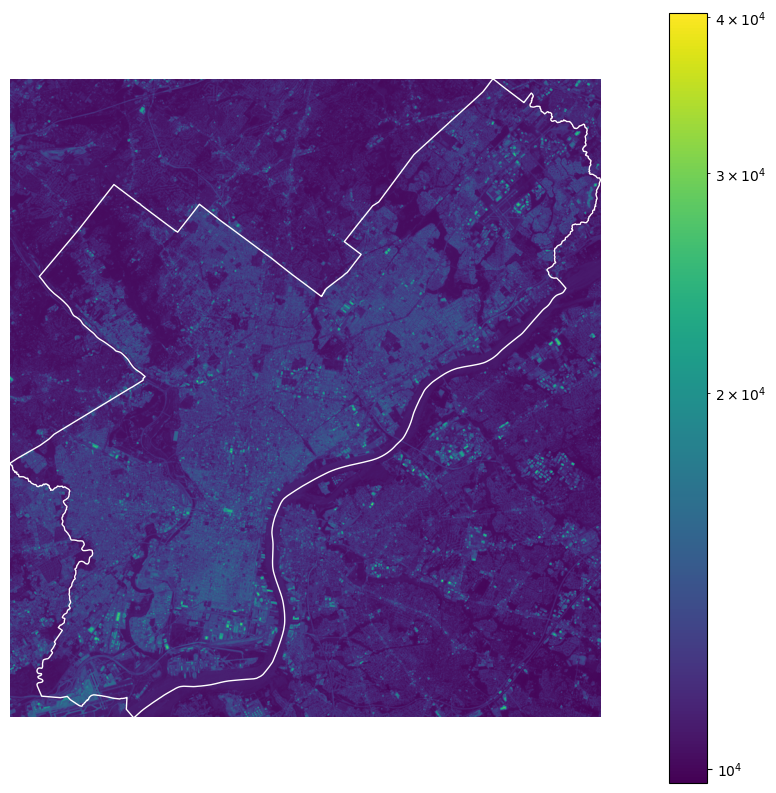

In [43]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# The extent of the data
landsat_extent = [
    landsat.bounds.left,
    landsat.bounds.right,
    landsat.bounds.bottom,
    landsat.bounds.top,
]

# Plot!
img = ax.imshow(data, norm=mcolors.LogNorm(), extent=landsat_extent)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar and turn off axis lines
plt.colorbar(img)
ax.set_axis_off()

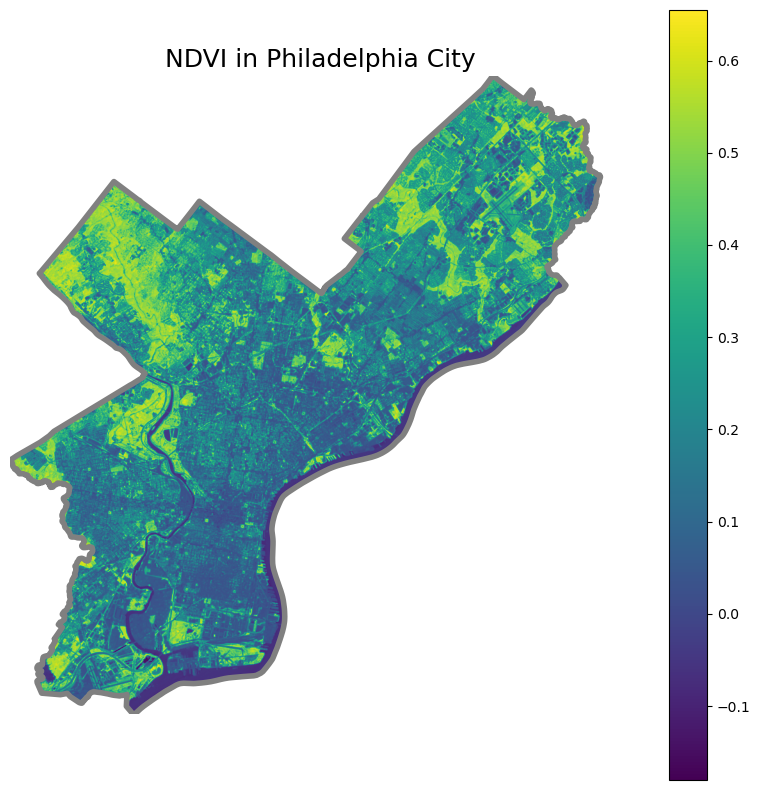

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI_c, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia City", fontsize=18);

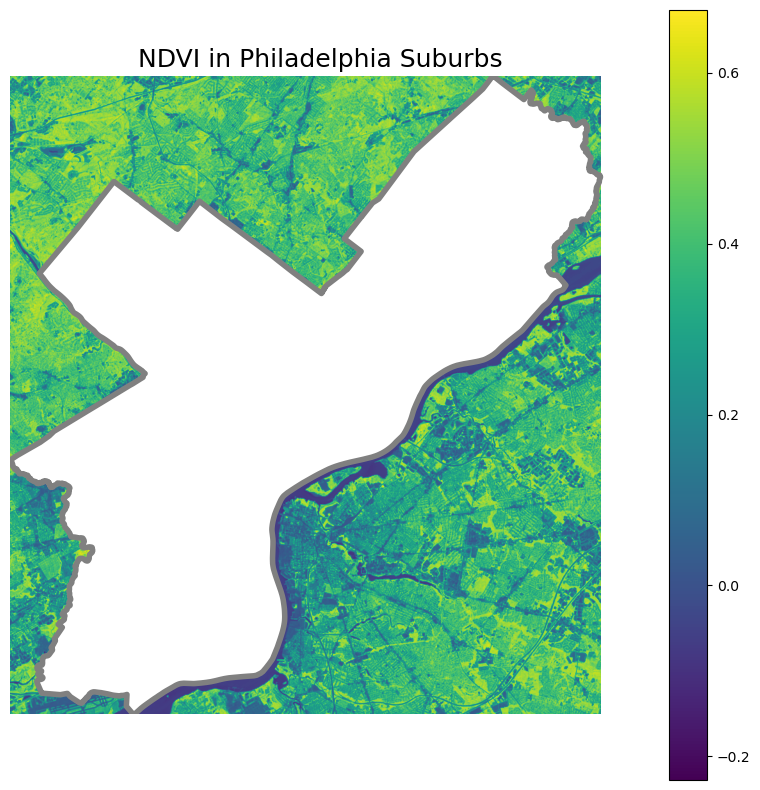

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI_s, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia Suburbs", fontsize=18);

### 2.1.4 Calculate the median NDVI within the city and within the suburbs

* Calculate the median value from your NDVI arrays for the city and suburbs
* Numpy's `nanmedian` function will be useful for ignoring NaN elements
* Print out the median values. Which has a higher NDVI: the city or suburbs?

In [46]:
np.nanmedian(NDVI_c)

0.20268593532493442

In [47]:
np.nanmedian(NDVI_s)

0.3746654463028859

#### Suburbs have a higher median NDVI

## 2.2 Calculating the NDVI for Philadelphia's street treets

### 2.2.1 Load the street tree data

The data is available in the "data/" folder. It has been downloaded from [OpenDataPhilly](https://www.opendataphilly.org/dataset/ppr-tree-canopy). It contains the locations of abot 2,500 street trees in Philadelphia.

In [48]:
philly_tree = gpd.read_file("./data/ppr_tree_canopy_points_2015.geojson")

### 2.2.2 Calculate the NDVI values at the locations of the street trees

* Use the rasterstats package to calculate the NDVI values at the locations of the street trees.
* Since these are point geometries, you can calculate either the median or the mean statistic (only one pixel will contain each point).

In [49]:
from rasterstats import zonal_stats

In [50]:
# Convert to the landsat CRS
philly_tree = philly_tree.to_crs(epsg=landsat.crs.to_epsg())
# Calculate the zonal statistics
stats_trees = zonal_stats(
    philly_tree, # Vector data as GeoDataFrame 
    NDVI_c, # Raster data as Numpy array
    affine=landsat.transform, # Geospatial info via affine transform
    stats=["mean", "median"]
)

/Users/hangzhao/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [51]:
# Store the median value in the data frame
tree_median_ndvi = [stats_dict["median"] for stats_dict in stats_trees]
philly_tree["median_NDVI"] = tree_median_ndvi

### 2.2.3 Plotting the results

Make two plots of the results:

1. A histogram of the NDVI values, using matplotlib's `hist` function. Include a vertical line that marks the NDVI = 0 threshold
1. A plot of the street tree points, colored by the NDVI value, using geopandas' `plot` function. Include the city limits boundary on your plot.

The figures should be clear and well-styled, with for example, labels for axes, legends, and clear color choices. 

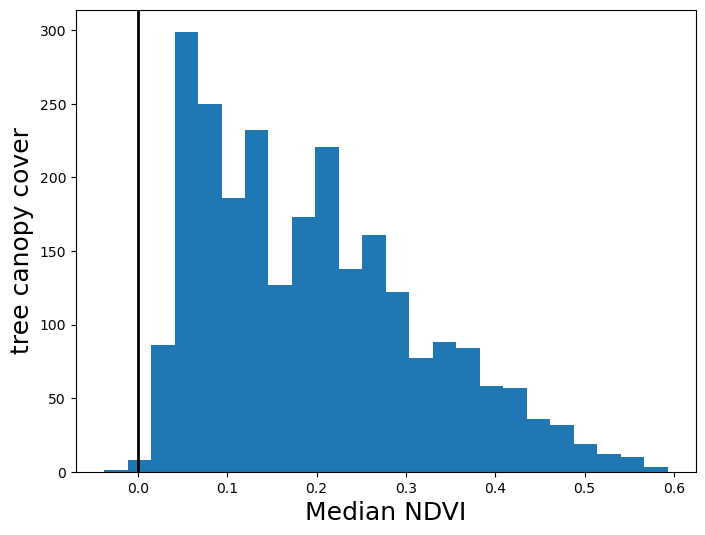

In [52]:
# Initialize
fig, ax = plt.subplots(figsize=(8, 6))

# Plot a quick histogram
ax.hist(philly_tree["median_NDVI"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Median NDVI", fontsize=18)
ax.set_ylabel("tree canopy cover", fontsize=18);

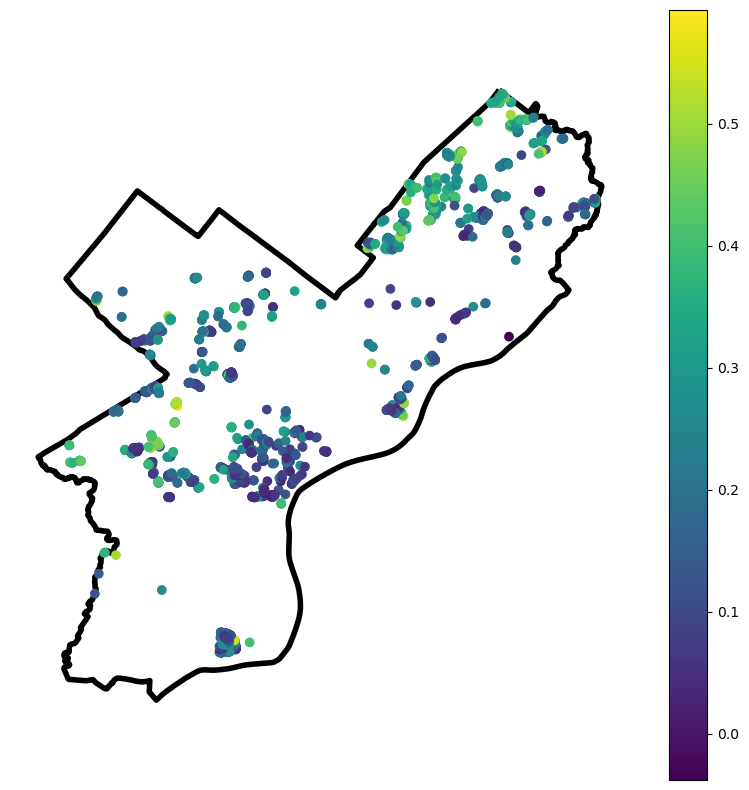

In [53]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=4)

# Plot the median NDVI
philly_tree.plot(column="median_NDVI", legend=True, ax=ax, cmap="viridis")

# Format
ax.set_axis_off()